In [1]:
!pip install  --queit yfinance


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --queit


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
from scipy import stats
import time
from pandas_datareader import data as pdr
import datetime as dt
import numpy as np

sns.set_style('whitegrid')
%matplotlib inline



In [3]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
weights = np.array([0.25, 0.25, 0.25, 0.25])

start = dt.datetime(2020, 1, 1)
end = dt.datetime.today()

prices = pd.DataFrame() #index = pd.date_range(start,end)

for ticker in tickers:
  print(f"Fetching {ticker}...", end = " ")
  try:
    df = yf.Ticker(ticker).history(
        start = start.strftime('%Y-%m-%d'),
        end = end.strftime('%Y-%m-%d'),
        auto_adjust = True,
    )
    series = df['Close']
    print("✔️ yfinance", end = "")
  except Exception as e:
    print(f" ❌yfinance ({e}); falling back to Stooq", end = "")
    df2 = pdr.DataReader(ticker, 'stooq', start, end)
    df2 = df2.sort_index()
    series = df2['Close']
  prices[ticker] = series
  time.sleep(1)
  print()

prices = prices.dropna(how = 'all').ffill().bfill()

print(prices.tail())

Fetching AAPL... ✔️ yfinance
Fetching MSFT... ✔️ yfinance
Fetching GOOGL... ✔️ yfinance
Fetching AMZN... ✔️ yfinance
                                 AAPL        MSFT       GOOGL        AMZN
Date                                                                     
2025-06-17 00:00:00-04:00  195.639999  478.040009  175.949997  214.820007
2025-06-18 00:00:00-04:00  196.580002  480.239990  173.320007  212.520004
2025-06-20 00:00:00-04:00  201.000000  477.399994  166.639999  209.690002
2025-06-23 00:00:00-04:00  201.500000  486.000000  165.190002  208.470001
2025-06-24 00:00:00-04:00  200.300003  490.109985  166.770004  212.770004


In [4]:
logR = np.log(prices / prices.shift(1)).dropna()
logR.head()

,AAPL,MSFT,GOOGL,AMZN
Date,,,,
2020-01-03 00:00:00-05:00,-0.009770,-0.012530,-0.005245,-0.012213
2020-01-06 00:00:00-05:00,0.007937,0.002582,0.026305,0.014776
2020-01-07 00:00:00-05:00,-0.004714,-0.009160,-0.001933,0.002089
2020-01-08 00:00:00-05:00,0.015958,0.015803,0.007092,-0.007839
2020-01-09 00:00:00-05:00,0.021019,0.012416,0.010443,0.004788


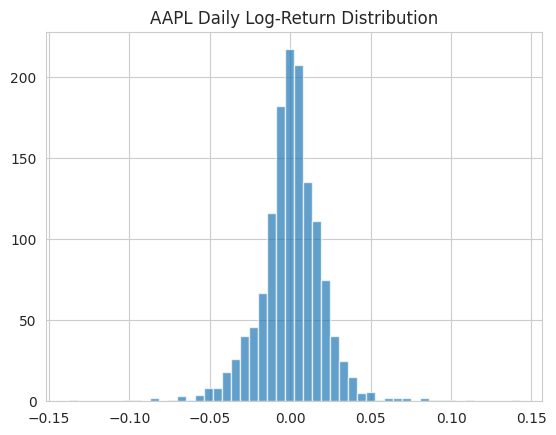

In [5]:
logR['AAPL'].hist(bins = 50, alpha = 0.7)
plt.title('AAPL Daily Log-Return Distribution')
plt.show()

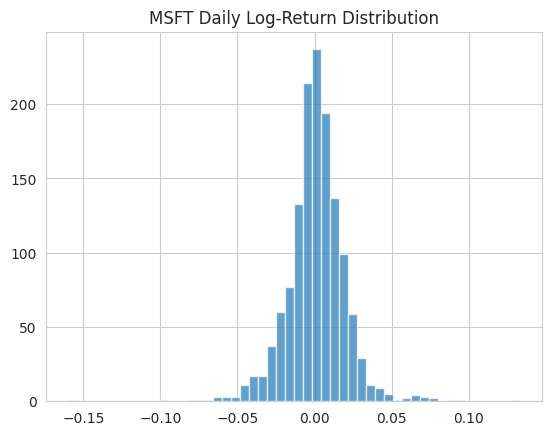

In [6]:
logR['MSFT'].hist(bins = 50, alpha = 0.7)
plt.title('MSFT Daily Log-Return Distribution')
plt.show()

In [7]:
summary = pd.DataFrame({
    'Mean' : logR.mean(),
    'Variance' : logR.var(),
    'Skewness' : logR.skew(),
    'Kurtosis' : logR.kurtosis()
})
summary

,Mean,Variance,Skewness,Kurtosis
AAPL,0.000738,0.000421,0.021786,6.257710
MSFT,0.000846,0.000368,-0.169922,7.521765
GOOGL,0.000652,0.000428,-0.224225,3.634325
AMZN,0.000587,0.000518,-0.070785,4.205239


In [8]:
mu_norm, sigma_norm = logR.stack().mean(), logR.stack().std(ddof = 1)

N = logR.size
z95 = stats.norm.ppf(0.975)
ci_mu_norm = (mu_norm - z95 * sigma_norm / np.sqrt(N),
              mu_norm + z95 * sigma_norm / np.sqrt(N))

df = N-1
chi2_low, chi2_high = stats.chi2.ppf([0.025, 0.975], df)
ci_sigma_norm = (sigma_norm*np.sqrt(df/chi2_high),
                 sigma_norm*np.sqrt(df/chi2_low))

print("Normal Fit:")
print(f" µ = {mu_norm:.5f}, 95% CI {ci_mu_norm}")
print(f" σ = {sigma_norm:.5f}, 95% CI {ci_sigma_norm}")

Normal Fit:
 µ = 0.00071, 95% CI (np.float64(0.00015554653772089809), np.float64(0.001256303623844018))
 σ = 0.02083, 95% CI (np.float64(0.020443454946900426), np.float64(0.021222131241800023))


In [9]:
returns_flat=logR.stack().values
df_t,mu_t,sigma_t=stats.t.fit(returns_flat)

In [11]:
B=1000
estimates =np.array([stats.t.fit(np.random.choice(returns_flat,size=N,replace=True))
                     for _ in range( B)])
ci_mu_t =np.percentile(estimates[:,1], [2.5, 97.5])
ci_sigma_t =np.percentile(estimates[:,2], [2.5, 97.5])
print("Student-t Fit:")
print(f" df={df_t:.1f}, µ={mu_t:.5f}, σ={sigma_t:.5f}")
print(f" µ 95% CI {ci_mu_t}")
print(f" σ 95% CI {ci_sigma_t}")




Student-t Fit:
 df=3.7, µ=0.00105, σ=0.01440
 µ 95% CI [0.00060508 0.00152666]
 σ 95% CI [0.01389509 0.01490173]


In [12]:
portR =logR.dot(weights)
µ_p=portR.mean()
σ_p=portR.std(ddof=1)
z05=stats.norm.ppf(0.95)
VaR_norm= -(µ_p+z05*σ_p)
print(f"VaR_norm={VaR_norm:.5f}")

VaR_norm=-0.03042


In [13]:
t05=stats.t.ppf(0.05,df_t)
print(f"t05={t05:.5f}")
VaR_t =-(mu_t + sigma_t *t05)*1
print(f"VaR_t={VaR_t:.5f}")

t05=-2.19107
VaR_t=0.03050


In [14]:
t_stat ,p_val=stats.ttest_1samp(portR ,0.0)
print(f"t_stat={t_stat:.5f}, p_val={p_val:.5f}")
if p_val<0.05:
  print("Reject H0: mean return is significantly different from zero")
else:
  print("Fail to reject H0 ")

t_stat=1.44914, p_val=0.14753
Fail to reject H0 


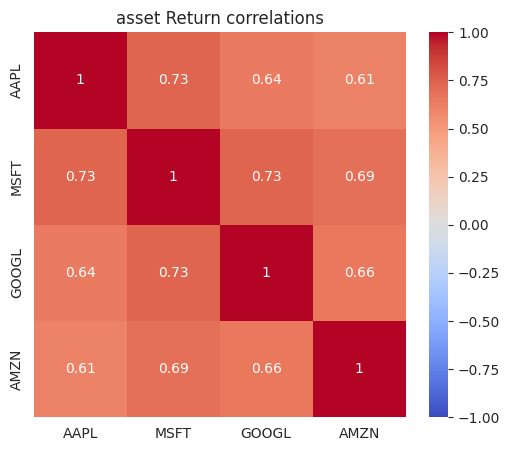

σ_weighted=0.02079
σ_p=0.01806


In [15]:
import seaborn as sns
corr =logR.corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr ,annot=True , cmap='coolwarm',vmin=-1,vmax=1)
plt.title('asset Return correlations')
plt.show()
σ_i=logR.std()
σ_weighted =np.dot(weights,σ_i)
print(f"σ_weighted={σ_weighted:.5f}")
print(f"σ_p={σ_p:.5f}")


Max Drawdown: -43.98%
From 2021-12-10 to 2023-01-05


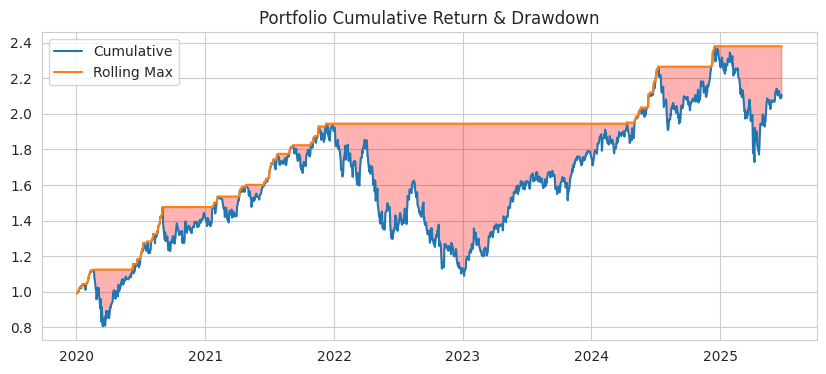

In [16]:

cum_ret = (prices / prices.iloc[0]).prod(axis=1)

cum_port = (portR + 1).cumprod()

rolling_max = cum_port.cummax()
drawdown = (cum_port - rolling_max) / rolling_max

max_dd = drawdown.min()
end_date = drawdown.idxmin()
start_date = cum_port[:end_date].idxmax()

print(f"Max Drawdown: {max_dd:.2%}")
print(f"From {start_date.date()} to {end_date.date()}")


plt.figure(figsize=(10,4))
plt.plot(cum_port, label='Cumulative')
plt.plot(rolling_max, label='Rolling Max')
plt.fill_between(drawdown.index, cum_port, rolling_max,
                 where=drawdown<0, color='red', alpha=0.3)
plt.title('Portfolio Cumulative Return & Drawdown')
plt.legend()
plt.show()

In [19]:

alpha = 0.05

es_hist =- portR[portR <= np.percentile(portR, 5)].mean()

es_norm =-( -μ_p - σ_p * stats.norm.pdf(z05) / alpha)

print("Historical ES (95%):", es_hist)
print("Parametric Normal ES (95%):", es_norm)



Historical ES (95%): 0.04210395766980562
Parametric Normal ES (95%): 0.03796561820873816


In [25]:
window = 100  # or whatever fits your strategy

var_series = -(portR.rolling(window).mean() + portR.rolling(window).std() * z05)

exceptions = portR < var_series
num_exc = exceptions.sum()
total = len(portR)

print(f"Exceptions: {num_exc}/{total} days ({num_exc/total:.2%}, expected ~5%)")

Exceptions: 72/1375 days (5.24%, expected ~5%)


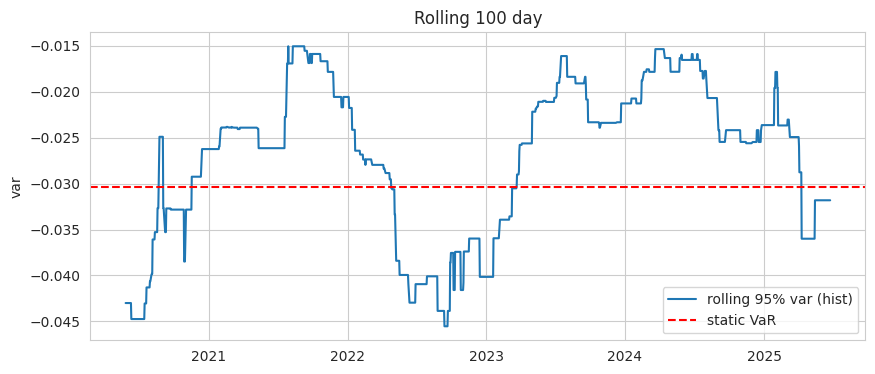

In [27]:
roll_var=portR.rolling(window).quantile(0.05).dropna()
plt.figure(figsize=(10,4))
plt.plot(roll_var,label ="rolling 95% var (hist)")
plt.axhline(VaR_norm ,color='red',linestyle='--',label="static VaR")
plt.legend()
plt.ylabel('var')
plt.title('Rolling 100 day')
plt.show()

In [30]:
jb_stat ,jb_p =stats.jarque_bera(portR)
print(f"jb_stat={jb_stat:.5f},jb_p={jb_p:.5f}")
if jb_p<0.05:
  print("reject normality at 5% level ")
else:
  print('cannot reject normality')

jb_stat=1239.56081,jb_p=0.00000
reject normality at 5% level 
